In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torchinfo import summary
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
# Om			\Omega_m
# Obh2			\Omega_{b}h^2
# h	
datafile = 'chains/LCDM_phy_HD_nested_dynesty_multi_1.txt'

In [4]:
class LoadDataSet(torch.utils.data.Dataset):
    '''
    Prepare the dataset for regression
    '''
    def __init__(self, X, y, scale_data=False):
        if not torch.is_tensor(X) and not torch.is_tensor(y):
            # Apply scaling if necessary
            if scale_data:
                X = StandardScaler().fit_transform(X)
            self.X = torch.from_numpy(X)
            self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [5]:
class MLP(nn.Module):
    '''
    Multilayer Perceptron for regression.
    '''
    def __init__(self):
        super().__init__()
        ncols = 3
        self.layers = nn.Sequential(
          nn.Linear(ncols, 200),
          nn.ReLU(),
          nn.Linear(200, 200),
          nn.ReLU(),
          nn.Linear(200, 1)
        )


    def forward(self, x):
        '''
          Forward pass
        '''
        return self.layers(x)

In [6]:
if __name__ == '__main__':
    # Set fixed random number seed
    torch.manual_seed(42)
  
    # Load Boston dataset
    X = np.loadtxt(datafile, usecols=(2,3,4))
    y = np.loadtxt(datafile, usecols=1).reshape(-1, 1)
    randomize = np.random.permutation(len(X))
    X = X[randomize]
    y = y[randomize]
    print(np.shape(X), np.shape(y))
    X_test, y_test = X[:100, :], y[:100, :]
    X, y = X[100:, :], y[100:, :]
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

(1036, 3) (1036, 1)


In [7]:
dataset_train = LoadDataSet(X_train, y_train)
dataset_val = LoadDataSet(X_val, y_val)
# dataset_test = LoadDataSet(X_test, y_test)
X_test, y_test = torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float()

In [8]:
trainloader = torch.utils.data.DataLoader(dataset_train, batch_size=1, shuffle=True, num_workers=1)
validloader = torch.utils.data.DataLoader(dataset_val, batch_size=1, shuffle=True, num_workers=1)

In [9]:
# Initialize the MLP
mlp = MLP()
mlp.float()
# Define the loss function and optimizer
loss_function = nn.L1Loss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)

In [10]:
summary(mlp, batch_size=-1)

Layer (type:depth-idx)                   Param #
MLP                                      --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       800
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       40,200
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       201
Total params: 41,201
Trainable params: 41,201
Non-trainable params: 0

In [11]:
# Run the training loop
history_train = np.empty((1,))
history_val = np.empty((1,))
nepochs=50
for epoch in range(0, nepochs): # 5 epochs at maximum  
    # Print epoch
    print(f'Starting epoch {epoch+1}')

    # Set current loss value
    current_loss = 0.0

    # Iterate over the DataLoader for training data
    for i, data in enumerate(trainloader, 0):

          # Get and prepare inputs
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))

        # Zero the gradients
        optimizer.zero_grad()

        # Perform forward pass
        outputs = mlp(inputs)

        # Compute loss
        loss = loss_function(outputs, targets)
        # Perform backward pass
        loss.backward()

        # Perform optimization
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        if i % 10 == 0:
            print('Loss after mini-batch %5d: %.3f' %
#                 (i + 1, current_loss / 500))
                  (i + 1, loss.item()))
            current_loss = 0.0
    history_train = np.append(history_train, current_loss)

    
    valid_loss = 0.0
    mlp.eval()     # Optional when not using Model Specific layer
    for i, data in enumerate(validloader, 0):
        # Get and prepare inputs
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))
        
        output_val = mlp(inputs)
        valid_loss = loss_function(output_val, targets)
    
        valid_loss += loss.item()
    history_val = np.append(history_val, valid_loss.item())
    print('Training Loss: {:.3f} \t\t Validation Loss:'\
         '{:.3f}'.format(loss.item(), valid_loss.item()))
#     print('Training Loss: {:.3f} \t\t Validation Loss:'\
#           '{:.3f}'.format(current_loss / len(trainloader), valid_loss / len(validloader)))
#     if min_valid_loss > valid_loss:
#         print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
#         min_valid_loss = valid_loss
#         # Saving State Dict
#         torch.save(model.state_dict(), 'saved_model.pth')

# Process is complete.
print('Training process has finished.')

Starting epoch 1
Loss after mini-batch     1: 26.837
Loss after mini-batch    11: 65.791
Loss after mini-batch    21: 15.771
Loss after mini-batch    31: 18.729
Loss after mini-batch    41: 6.745
Loss after mini-batch    51: 11.396
Loss after mini-batch    61: 7.034
Loss after mini-batch    71: 9.380
Loss after mini-batch    81: 7.546
Loss after mini-batch    91: 6.056
Loss after mini-batch   101: 14.874
Loss after mini-batch   111: 5.768
Loss after mini-batch   121: 5.607
Loss after mini-batch   131: 5.324
Loss after mini-batch   141: 10.645
Loss after mini-batch   151: 5.002
Loss after mini-batch   161: 99.939
Loss after mini-batch   171: 4.500
Loss after mini-batch   181: 4.247
Loss after mini-batch   191: 6.383
Loss after mini-batch   201: 4.043
Loss after mini-batch   211: 16.813
Loss after mini-batch   221: 3.354
Loss after mini-batch   231: 3.548
Loss after mini-batch   241: 2.289
Loss after mini-batch   251: 17.298
Loss after mini-batch   261: 1.567
Loss after mini-batch   271:

Loss after mini-batch    81: 0.989
Loss after mini-batch    91: 0.555
Loss after mini-batch   101: 0.620
Loss after mini-batch   111: 0.588
Loss after mini-batch   121: 4.675
Loss after mini-batch   131: 0.706
Loss after mini-batch   141: 0.782
Loss after mini-batch   151: 0.382
Loss after mini-batch   161: 11.947
Loss after mini-batch   171: 5.167
Loss after mini-batch   181: 0.809
Loss after mini-batch   191: 0.298
Loss after mini-batch   201: 2.461
Loss after mini-batch   211: 0.188
Loss after mini-batch   221: 0.790
Loss after mini-batch   231: 16.800
Loss after mini-batch   241: 22.988
Loss after mini-batch   251: 0.164
Loss after mini-batch   261: 3.977
Loss after mini-batch   271: 0.477
Loss after mini-batch   281: 0.380
Loss after mini-batch   291: 0.090
Loss after mini-batch   301: 9.129
Loss after mini-batch   311: 9.792
Loss after mini-batch   321: 0.546
Loss after mini-batch   331: 0.532
Loss after mini-batch   341: 1.481
Loss after mini-batch   351: 0.388
Loss after mini-b

Loss after mini-batch   171: 2.248
Loss after mini-batch   181: 0.087
Loss after mini-batch   191: 24.152
Loss after mini-batch   201: 1.188
Loss after mini-batch   211: 0.502
Loss after mini-batch   221: 0.459
Loss after mini-batch   231: 4.043
Loss after mini-batch   241: 4.303
Loss after mini-batch   251: 0.501
Loss after mini-batch   261: 0.645
Loss after mini-batch   271: 0.187
Loss after mini-batch   281: 1.485
Loss after mini-batch   291: 0.797
Loss after mini-batch   301: 0.028
Loss after mini-batch   311: 29.063
Loss after mini-batch   321: 0.471
Loss after mini-batch   331: 0.577
Loss after mini-batch   341: 0.501
Loss after mini-batch   351: 0.275
Loss after mini-batch   361: 0.570
Loss after mini-batch   371: 0.598
Loss after mini-batch   381: 0.571
Loss after mini-batch   391: 0.090
Loss after mini-batch   401: 0.509
Loss after mini-batch   411: 0.100
Loss after mini-batch   421: 2.182
Loss after mini-batch   431: 0.942
Loss after mini-batch   441: 7.921
Loss after mini-ba

Loss after mini-batch   261: 0.427
Loss after mini-batch   271: 0.305
Loss after mini-batch   281: 0.358
Loss after mini-batch   291: 0.359
Loss after mini-batch   301: 0.463
Loss after mini-batch   311: 2.251
Loss after mini-batch   321: 5.493
Loss after mini-batch   331: 0.405
Loss after mini-batch   341: 0.952
Loss after mini-batch   351: 19.973
Loss after mini-batch   361: 0.592
Loss after mini-batch   371: 0.335
Loss after mini-batch   381: 11.377
Loss after mini-batch   391: 15.305
Loss after mini-batch   401: 0.495
Loss after mini-batch   411: 1.008
Loss after mini-batch   421: 45.516
Loss after mini-batch   431: 1.006
Loss after mini-batch   441: 0.573
Loss after mini-batch   451: 0.871
Loss after mini-batch   461: 0.329
Loss after mini-batch   471: 0.671
Loss after mini-batch   481: 0.135
Loss after mini-batch   491: 4.505
Loss after mini-batch   501: 0.768
Loss after mini-batch   511: 0.307
Loss after mini-batch   521: 0.388
Loss after mini-batch   531: 5.040
Loss after mini-

Loss after mini-batch   291: 25.601
Loss after mini-batch   301: 0.427
Loss after mini-batch   311: 13.266
Loss after mini-batch   321: 5.293
Loss after mini-batch   331: 0.337
Loss after mini-batch   341: 8.475
Loss after mini-batch   351: 3.556
Loss after mini-batch   361: 3.081
Loss after mini-batch   371: 0.722
Loss after mini-batch   381: 0.505
Loss after mini-batch   391: 0.298
Loss after mini-batch   401: 8.216
Loss after mini-batch   411: 0.613
Loss after mini-batch   421: 0.504
Loss after mini-batch   431: 4.169
Loss after mini-batch   441: 0.510
Loss after mini-batch   451: 0.522
Loss after mini-batch   461: 21.517
Loss after mini-batch   471: 0.100
Loss after mini-batch   481: 0.974
Loss after mini-batch   491: 0.533
Loss after mini-batch   501: 2.127
Loss after mini-batch   511: 13.935
Loss after mini-batch   521: 0.472
Loss after mini-batch   531: 15.551
Loss after mini-batch   541: 2.507
Loss after mini-batch   551: 0.191
Loss after mini-batch   561: 22.104
Loss after min

Loss after mini-batch   351: 0.402
Loss after mini-batch   361: 3.149
Loss after mini-batch   371: 0.855
Loss after mini-batch   381: 0.073
Loss after mini-batch   391: 0.372
Loss after mini-batch   401: 0.384
Loss after mini-batch   411: 0.048
Loss after mini-batch   421: 9.707
Loss after mini-batch   431: 0.142
Loss after mini-batch   441: 4.005
Loss after mini-batch   451: 0.162
Loss after mini-batch   461: 1.438
Loss after mini-batch   471: 0.608
Loss after mini-batch   481: 0.568
Loss after mini-batch   491: 18.204
Loss after mini-batch   501: 0.326
Loss after mini-batch   511: 0.585
Loss after mini-batch   521: 11.319
Loss after mini-batch   531: 0.579
Loss after mini-batch   541: 7.083
Loss after mini-batch   551: 8.683
Loss after mini-batch   561: 0.467
Loss after mini-batch   571: 0.362
Loss after mini-batch   581: 0.366
Loss after mini-batch   591: 0.589
Loss after mini-batch   601: 0.547
Loss after mini-batch   611: 4.732
Loss after mini-batch   621: 0.415
Loss after mini-ba

Loss after mini-batch   401: 0.673
Loss after mini-batch   411: 0.372
Loss after mini-batch   421: 34.449
Loss after mini-batch   431: 0.858
Loss after mini-batch   441: 0.377
Loss after mini-batch   451: 0.649
Loss after mini-batch   461: 0.526
Loss after mini-batch   471: 6.126
Loss after mini-batch   481: 0.458
Loss after mini-batch   491: 0.141
Loss after mini-batch   501: 17.889
Loss after mini-batch   511: 0.171
Loss after mini-batch   521: 2.508
Loss after mini-batch   531: 0.431
Loss after mini-batch   541: 0.523
Loss after mini-batch   551: 0.506
Loss after mini-batch   561: 5.003
Loss after mini-batch   571: 0.216
Loss after mini-batch   581: 0.142
Loss after mini-batch   591: 0.246
Loss after mini-batch   601: 0.279
Loss after mini-batch   611: 0.003
Loss after mini-batch   621: 0.180
Loss after mini-batch   631: 0.430
Loss after mini-batch   641: 0.242
Loss after mini-batch   651: 0.366
Loss after mini-batch   661: 0.578
Loss after mini-batch   671: 4.369
Loss after mini-ba

Loss after mini-batch   451: 13.511
Loss after mini-batch   461: 0.120
Loss after mini-batch   471: 0.785
Loss after mini-batch   481: 0.312
Loss after mini-batch   491: 12.696
Loss after mini-batch   501: 21.546
Loss after mini-batch   511: 15.589
Loss after mini-batch   521: 0.956
Loss after mini-batch   531: 0.833
Loss after mini-batch   541: 1.327
Loss after mini-batch   551: 1.218
Loss after mini-batch   561: 0.814
Loss after mini-batch   571: 0.134
Loss after mini-batch   581: 5.747
Loss after mini-batch   591: 0.254
Loss after mini-batch   601: 0.465
Loss after mini-batch   611: 0.833
Loss after mini-batch   621: 0.390
Loss after mini-batch   631: 12.283
Loss after mini-batch   641: 0.266
Loss after mini-batch   651: 0.228
Loss after mini-batch   661: 0.510
Loss after mini-batch   671: 0.372
Loss after mini-batch   681: 0.189
Loss after mini-batch   691: 0.206
Loss after mini-batch   701: 0.417
Loss after mini-batch   711: 0.420
Loss after mini-batch   721: 3.058
Loss after mini

Loss after mini-batch   491: 0.953
Loss after mini-batch   501: 0.323
Loss after mini-batch   511: 51.648
Loss after mini-batch   521: 30.486
Loss after mini-batch   531: 2.602
Loss after mini-batch   541: 0.436
Loss after mini-batch   551: 1.678
Loss after mini-batch   561: 2.414
Loss after mini-batch   571: 0.063
Loss after mini-batch   581: 0.761
Loss after mini-batch   591: 4.756
Loss after mini-batch   601: 0.453
Loss after mini-batch   611: 5.731
Loss after mini-batch   621: 1.051
Loss after mini-batch   631: 0.689
Loss after mini-batch   641: 0.206
Loss after mini-batch   651: 0.111
Loss after mini-batch   661: 0.377
Loss after mini-batch   671: 0.306
Loss after mini-batch   681: 21.490
Loss after mini-batch   691: 0.056
Loss after mini-batch   701: 11.049
Loss after mini-batch   711: 0.731
Loss after mini-batch   721: 0.076
Loss after mini-batch   731: 90.710
Loss after mini-batch   741: 3.057
Training Loss: 4.438 		 Validation Loss:29.038
Starting epoch 26
Loss after mini-batc

Loss after mini-batch   581: 0.072
Loss after mini-batch   591: 0.205
Loss after mini-batch   601: 0.518
Loss after mini-batch   611: 56.613
Loss after mini-batch   621: 0.480
Loss after mini-batch   631: 0.015
Loss after mini-batch   641: 40.213
Loss after mini-batch   651: 0.691
Loss after mini-batch   661: 0.445
Loss after mini-batch   671: 0.066
Loss after mini-batch   681: 0.359
Loss after mini-batch   691: 0.060
Loss after mini-batch   701: 0.050
Loss after mini-batch   711: 0.238
Loss after mini-batch   721: 0.091
Loss after mini-batch   731: 12.162
Loss after mini-batch   741: 0.040
Training Loss: 32.088 		 Validation Loss:32.464
Starting epoch 29
Loss after mini-batch     1: 1.522
Loss after mini-batch    11: 1.370
Loss after mini-batch    21: 68.690
Loss after mini-batch    31: 2.327
Loss after mini-batch    41: 0.484
Loss after mini-batch    51: 0.850
Loss after mini-batch    61: 0.874
Loss after mini-batch    71: 1.880
Loss after mini-batch    81: 10.899
Loss after mini-bat

Loss after mini-batch   621: 0.464
Loss after mini-batch   631: 1.645
Loss after mini-batch   641: 12.121
Loss after mini-batch   651: 0.114
Loss after mini-batch   661: 1.651
Loss after mini-batch   671: 7.357
Loss after mini-batch   681: 57.169
Loss after mini-batch   691: 0.115
Loss after mini-batch   701: 9.044
Loss after mini-batch   711: 4.002
Loss after mini-batch   721: 0.364
Loss after mini-batch   731: 0.055
Loss after mini-batch   741: 0.438
Training Loss: 0.623 		 Validation Loss:0.925
Starting epoch 32
Loss after mini-batch     1: 0.096
Loss after mini-batch    11: 0.180
Loss after mini-batch    21: 2.471
Loss after mini-batch    31: 0.436
Loss after mini-batch    41: 47.985
Loss after mini-batch    51: 7.610
Loss after mini-batch    61: 0.581
Loss after mini-batch    71: 0.005
Loss after mini-batch    81: 0.392
Loss after mini-batch    91: 10.462
Loss after mini-batch   101: 1.561
Loss after mini-batch   111: 2.629
Loss after mini-batch   121: 0.117
Loss after mini-batch 

Loss after mini-batch   671: 1.043
Loss after mini-batch   681: 1.273
Loss after mini-batch   691: 0.846
Loss after mini-batch   701: 28.340
Loss after mini-batch   711: 0.531
Loss after mini-batch   721: 0.172
Loss after mini-batch   731: 0.592
Loss after mini-batch   741: 13.669
Training Loss: 0.012 		 Validation Loss:2.391
Starting epoch 35
Loss after mini-batch     1: 10.579
Loss after mini-batch    11: 0.137
Loss after mini-batch    21: 0.156
Loss after mini-batch    31: 0.304
Loss after mini-batch    41: 0.516
Loss after mini-batch    51: 0.093
Loss after mini-batch    61: 46.283
Loss after mini-batch    71: 0.007
Loss after mini-batch    81: 0.026
Loss after mini-batch    91: 0.242
Loss after mini-batch   101: 18.699
Loss after mini-batch   111: 0.819
Loss after mini-batch   121: 0.002
Loss after mini-batch   131: 0.074
Loss after mini-batch   141: 0.164
Loss after mini-batch   151: 0.622
Loss after mini-batch   161: 0.505
Loss after mini-batch   171: 0.941
Loss after mini-batch

Loss after mini-batch   701: 0.032
Loss after mini-batch   711: 0.648
Loss after mini-batch   721: 12.656
Loss after mini-batch   731: 0.285
Loss after mini-batch   741: 1.285
Training Loss: 0.006 		 Validation Loss:4.260
Starting epoch 38
Loss after mini-batch     1: 0.030
Loss after mini-batch    11: 0.548
Loss after mini-batch    21: 0.036
Loss after mini-batch    31: 0.400
Loss after mini-batch    41: 0.129
Loss after mini-batch    51: 0.372
Loss after mini-batch    61: 1.811
Loss after mini-batch    71: 5.607
Loss after mini-batch    81: 0.561
Loss after mini-batch    91: 0.024
Loss after mini-batch   101: 0.379
Loss after mini-batch   111: 0.208
Loss after mini-batch   121: 36.485
Loss after mini-batch   131: 0.026
Loss after mini-batch   141: 0.136
Loss after mini-batch   151: 2.365
Loss after mini-batch   161: 0.287
Loss after mini-batch   171: 0.101
Loss after mini-batch   181: 5.151
Loss after mini-batch   191: 2.959
Loss after mini-batch   201: 0.185
Loss after mini-batch   

Training Loss: 0.148 		 Validation Loss:0.217
Starting epoch 41
Loss after mini-batch     1: 0.779
Loss after mini-batch    11: 36.346
Loss after mini-batch    21: 0.054
Loss after mini-batch    31: 1.129
Loss after mini-batch    41: 0.078
Loss after mini-batch    51: 0.955
Loss after mini-batch    61: 0.265
Loss after mini-batch    71: 1.007
Loss after mini-batch    81: 32.748
Loss after mini-batch    91: 2.293
Loss after mini-batch   101: 0.203
Loss after mini-batch   111: 1.574
Loss after mini-batch   121: 0.062
Loss after mini-batch   131: 0.117
Loss after mini-batch   141: 1.118
Loss after mini-batch   151: 2.146
Loss after mini-batch   161: 0.030
Loss after mini-batch   171: 0.159
Loss after mini-batch   181: 3.109
Loss after mini-batch   191: 0.044
Loss after mini-batch   201: 6.813
Loss after mini-batch   211: 25.889
Loss after mini-batch   221: 23.024
Loss after mini-batch   231: 42.166
Loss after mini-batch   241: 2.791
Loss after mini-batch   251: 0.363
Loss after mini-batch

Loss after mini-batch    71: 0.025
Loss after mini-batch    81: 1.666
Loss after mini-batch    91: 3.396
Loss after mini-batch   101: 3.629
Loss after mini-batch   111: 1.565
Loss after mini-batch   121: 12.187
Loss after mini-batch   131: 2.530
Loss after mini-batch   141: 0.190
Loss after mini-batch   151: 4.434
Loss after mini-batch   161: 0.832
Loss after mini-batch   171: 0.144
Loss after mini-batch   181: 7.094
Loss after mini-batch   191: 0.379
Loss after mini-batch   201: 2.651
Loss after mini-batch   211: 0.158
Loss after mini-batch   221: 0.190
Loss after mini-batch   231: 0.002
Loss after mini-batch   241: 0.003
Loss after mini-batch   251: 0.082
Loss after mini-batch   261: 13.846
Loss after mini-batch   271: 15.774
Loss after mini-batch   281: 3.220
Loss after mini-batch   291: 0.086
Loss after mini-batch   301: 1.350
Loss after mini-batch   311: 4.018
Loss after mini-batch   321: 0.960
Loss after mini-batch   331: 17.728
Loss after mini-batch   341: 0.575
Loss after mini-

Loss after mini-batch   161: 3.873
Loss after mini-batch   171: 0.267
Loss after mini-batch   181: 3.301
Loss after mini-batch   191: 30.987
Loss after mini-batch   201: 0.014
Loss after mini-batch   211: 0.310
Loss after mini-batch   221: 2.046
Loss after mini-batch   231: 0.064
Loss after mini-batch   241: 6.126
Loss after mini-batch   251: 0.267
Loss after mini-batch   261: 2.767
Loss after mini-batch   271: 0.024
Loss after mini-batch   281: 16.247
Loss after mini-batch   291: 1.805
Loss after mini-batch   301: 0.229
Loss after mini-batch   311: 1.797
Loss after mini-batch   321: 9.080
Loss after mini-batch   331: 0.485
Loss after mini-batch   341: 2.028
Loss after mini-batch   351: 0.027
Loss after mini-batch   361: 4.152
Loss after mini-batch   371: 0.106
Loss after mini-batch   381: 3.495
Loss after mini-batch   391: 1.111
Loss after mini-batch   401: 0.958
Loss after mini-batch   411: 0.427
Loss after mini-batch   421: 0.035
Loss after mini-batch   431: 13.692
Loss after mini-b

Loss after mini-batch   281: 0.217
Loss after mini-batch   291: 0.528
Loss after mini-batch   301: 0.840
Loss after mini-batch   311: 2.565
Loss after mini-batch   321: 3.557
Loss after mini-batch   331: 7.951
Loss after mini-batch   341: 0.363
Loss after mini-batch   351: 49.288
Loss after mini-batch   361: 11.198
Loss after mini-batch   371: 0.067
Loss after mini-batch   381: 11.337
Loss after mini-batch   391: 20.456
Loss after mini-batch   401: 0.528
Loss after mini-batch   411: 0.754
Loss after mini-batch   421: 0.865
Loss after mini-batch   431: 0.895
Loss after mini-batch   441: 39.739
Loss after mini-batch   451: 0.239
Loss after mini-batch   461: 0.249
Loss after mini-batch   471: 0.060
Loss after mini-batch   481: 3.341
Loss after mini-batch   491: 0.373
Loss after mini-batch   501: 0.608
Loss after mini-batch   511: 4.517
Loss after mini-batch   521: 15.856
Loss after mini-batch   531: 0.366
Loss after mini-batch   541: 2.457
Loss after mini-batch   551: 0.366
Loss after min

In [12]:
# test = np.random.randn(13)
# torch usa tensores de torch y no numpy.darrays
dtype = torch.float
test = torch.randn((1, 3), device=device, dtype=dtype)

In [13]:
y_pred = mlp.forward(X_test)

In [14]:
y_pred[0].item()

7.240553855895996

In [15]:
X_test[0, 0], X_test[0]
# xtest = [x[0] for x in X_test]
ypred = [y[0].item() for y in y_pred]
ytest = [y[0].item() for y in y_test]
diff=np.array(ytest)-np.array(ypred)
len(diff)

100

(0.0, 4.5)

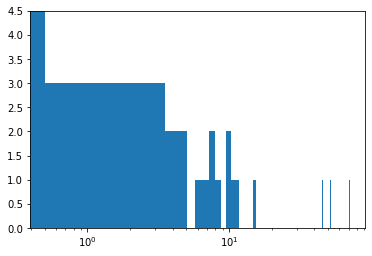

In [16]:
plt.hist(diff,bins=100)
plt.xscale('log')
plt.ylim(0,4.5)

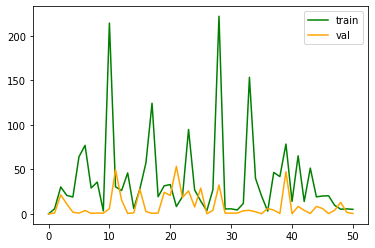

In [17]:
ep = np.arange(0, nepochs+1)
plt.plot(ep, history_train, label='train', color='green')
plt.plot(ep, history_val, label='val', color='orange')
plt.legend()

[113.162445] [42.093952]
[7.2725167] [7.240554]


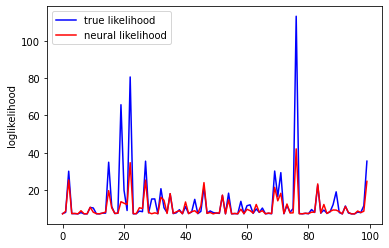

In [18]:
# sns.displot(y_test)
plt.plot(np.sort(y_test.detach().numpy()), color='blue', label='true likelihood')
plt.plot(np.sort(y_pred.detach().numpy()), color='red', label='neural likelihood')
plt.ylabel('loglikelihood')
plt.legend()
print(max(y_test.detach().numpy()), max(y_pred.detach().numpy()))
print(min(y_test.detach().numpy()), min(y_pred.detach().numpy()))

In [19]:
np.shape(y_pred), np.shape(y_test), np.shape(y_pred.detach().numpy())

(torch.Size([100, 1]), torch.Size([100, 1]), (100, 1))

In [20]:
np.shape(history_train), np.shape(history_val)

((51,), (51,))

(0.0, 60.0)

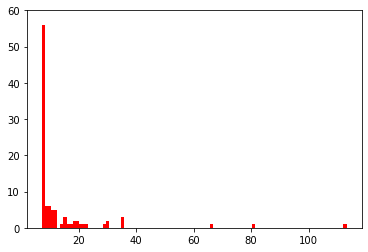

In [21]:
plt.hist(ytest, bins=len(ytest), color='red')
# plt.hist(ypred, bins=len(ypred), color='green')
plt.ylim(0,60)

In [22]:
len(ypred)==len(ytest)

True

In [23]:
len(ypred)

100